# VISUM Interpretability Hands-On Session 

## Part 1 - Cats vs. Dogs

### Dataset

In the first part of this class, we will be dealing with a **Cats vs. Dogs** dataset (https://www.kaggle.com/c/dogs-vs-cats). The dataset is composed of **25,000 images of cats and dogs**. The classification problem is, therefore, a **binary classification problem** with the final decision being either cat or dog. 

![alt text](aux_imgs/c_vs_d.png "Title")

For **time and memory related reasons**, we will be using a **subset** of the data, in this case, **500 images** (250 from each class). 

In [1]:
import pickle 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.optimizers import adam
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


### Deep Neural Network Architecture

To solve the **classification task** previously described, we will use a Deep Neural Network mainly based on the well known **VGG16 architecture** (https://arxiv.org/pdf/1409.1556). The implementation of the network will be done using **Keras** (https://keras.io/). 

In [2]:
def vgg16(inputs):
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', \
               name='block1_conv1')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', \
               name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', \
               name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', \
               name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', \
               name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', \
               name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', \
               name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', \
               name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    return x

We will also need a set of **Dense** layers to compute the **probabilities** for each class. Furthermore, two **Dropout** layers are also added for **regularization** purposes.

In [3]:
def clf_from_fts(inputs): 
    flat = Flatten()(inputs)
    dense1 = Dense(100, activation='relu', name='first_dense')(flat)
    dense1 = Dropout(0.3, name='dropout_1')(dense1)
    dense1 = Dense(20, activation='relu', name='second_dense')(dense1)
    dense1 = Dropout(0.2, name='dropout_2')(dense1)
    dense1 = Dense(2, activation='softmax', name='clf')(dense1)
    
    return dense1

### Pre-processing of the data

The **original image dimensions** of the dataset are **variable**. However, in order to be able to feed the network, the inputs need to have the same dimensions. For the sake of this hands-on session, we resized all **images** to **224x224**. It is also important to mention that the images are **RGB**, i.e., they have **three color channels**.   

<IPython.core.display.Javascript object>


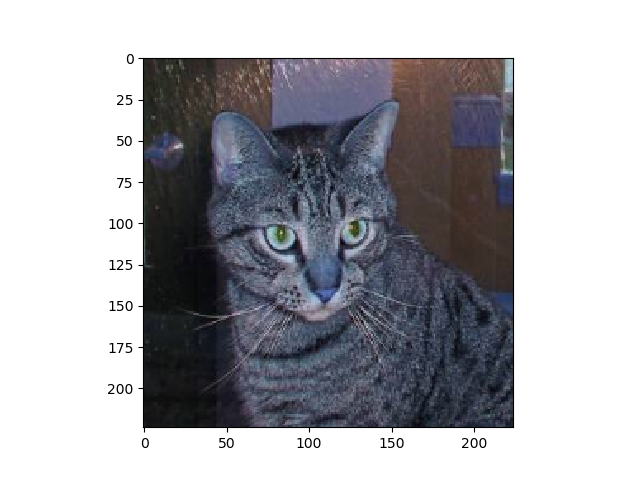

In [4]:
%matplotlib notebook

with open("Cats_vs_Dogs_Data/X.pickle",'rb') as fp: 
        X = pickle.load(fp)
X_orig = np.array(X)

# Show example
plt.imshow(X_orig[1])
plt.show()

As we want to use the **pre-trained ImageNet weights** ( http://www.image-net.org/ ), we have to **pre-process** the **images** in the same way. 

In [5]:
image = cv2.imread("cat_and_dog.png")
image_resized = cv2.resize(image, (224, 224))
input_img = np.reshape(image_resized, (1,224,224,3))

print(np.shape(input_img))
print(np.shape(X))

X = np.concatenate([X_orig, input_img])
X = np.array(X_orig, dtype='float')

X = preprocess_input(X) # pre-process for VGG16

image_for_analysis = X[-1]
X = X[:500]

print('X max: ', np.max(X))
print('X min: ', np.min(X))

(1, 224, 224, 3)
(500, 224, 224, 3)
X max:  151.061
X min:  -123.68


For the labels, we will use **one-hot encoding**.

In [6]:
with open("Cats_vs_Dogs_Data/y.pickle",'rb') as fp: 
        y = pickle.load(fp)
y = np.array(y)
    
print('Shape of y: ', y.shape)
labels = to_categorical(y)


X, labels = shuffle(X, labels, random_state=42)

Shape of y:  (500,)


### Define Keras Model

Input layer:

In [7]:
rows = X.shape[1]
cols = X.shape[2]
channels = X.shape[3]

inputs = Input((rows, cols, channels), name='input_for_cats_vs_dogs')

**VGG16 model** to save pre-trained weights:

In [8]:
conv_base = VGG16(input_shape=(rows, cols, channels), include_top=False, weights='imagenet') 
fts_vgg = conv_base(inputs)
model_vgg = Model(inputs=inputs, outputs=fts_vgg) # define a model 
model_vgg.summary() # print model
model_vgg.save_weights('Models/vgg_imagenet.hdf5') # to save pre-trained weights

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_for_cats_vs_dogs (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


Define **Model**:

In [9]:
vgg_fts = vgg16(inputs) 
clf = clf_from_fts(vgg_fts) 

model = Model(inputs=inputs, outputs=clf)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_for_cats_vs_dogs (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Load weights into model:

In [10]:
model.load_weights('Models/vgg_imagenet.hdf5', by_name=True)

Define optimizer and loss function:

In [11]:
model.compile(optimizer=adam(lr=0.00001), loss=categorical_crossentropy, metrics=['acc'])

### Training Process

**Split data** into training and validation:

In [12]:
sk = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for train_idx, validation_idx in sk.split(X, y): 
    X_train, X_validation = X[train_idx], X[validation_idx]
    y_train, y_validation = labels[train_idx], labels[validation_idx]

Generator for **data augmentation**:

In [13]:
def my_generator_final(X, y, minibatch_size):
    keras_datagen = ImageDataGenerator(rotation_range=0,
                                       zoom_range=0.05,
                                       width_shift_range=0.05,
                                       height_shift_range=0.05,
                                       horizontal_flip=True,
                                       )
    X = np.array(X)
    
    N = len(X)
    while True:
        indices = np.random.choice(N, N, False)
        
        for i in range(N // minibatch_size):
            batch_indices = indices[i*minibatch_size:(i+1)*minibatch_size]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]
            

            batch_X, batch_y = next(keras_datagen.flow(batch_X, \
                                              batch_y, \
                                              batch_size=minibatch_size, \
                                              shuffle=False))
            
            yield (batch_X, batch_y)

Define callback to **save model** that behaves better regarding the validation data:

In [14]:
checkpoint = ModelCheckpoint('Models/cats_vs_dogs_experiment.hdf5', monitor='val_loss', save_best_only=True, verbose=True)

Train the Model. 

**Note**: you can skip the next step because there is a model already trained. Nonetheless, if you want, after finishing this notebook you can build your own model and use again the interpretability methods presented. However, it should respect a time restriction of about 20 minutes for training.

In [ ]:
model.fit_generator(my_generator_final(X_train, y_train, 2), steps_per_epoch = X_train.shape[0]/2, epochs=50,\
                verbose=2, callbacks=[checkpoint], validation_data=(X_validation, y_validation))

**Load** best performing model:

In [15]:
model = load_model('Models/cats_vs_dogs.hdf5')

In [16]:
preds = model.predict(X_train, batch_size=1)
preds = np.argmax(preds, axis=1)
print(preds)

l = np.argmax(y_train, axis=1)
print(l)

[1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1
 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0
 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0
 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1
 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0
 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0
 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0
 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0
 0 0 0 1 1 1]
[1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 1 0 0 

Image to be analyzed: 

In [18]:
def processed_to_original(image): 
    image = image - np.min(image)
    image = image/np.max(image)
    
    return image

<IPython.core.display.Javascript object>


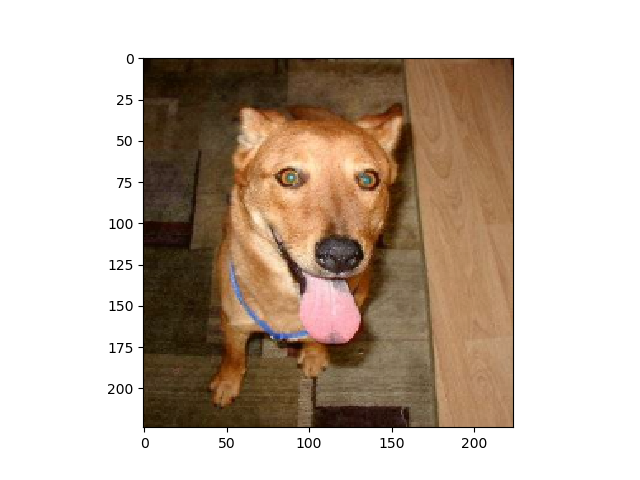

In [19]:
%matplotlib notebook

img_to_analyse = processed_to_original(X[0])

plt.imshow(img_to_analyse, cmap='plasma')
plt.show()

### Local Interpretable Model-agnostic Explanations (LIME)

- More information related to the toolbox may be found at https://github.com/marcotcr/lime. 

- Paper can be found at https://arxiv.org/abs/1602.04938. 

![alt text](aux_imgs/lime_paper.png "Title")

In [17]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [20]:
explainer = lime_image.LimeImageExplainer()

In [21]:
explanation = explainer.explain_instance(X_train[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

In [22]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=2, hide_rest=True)

<IPython.core.display.Javascript object>


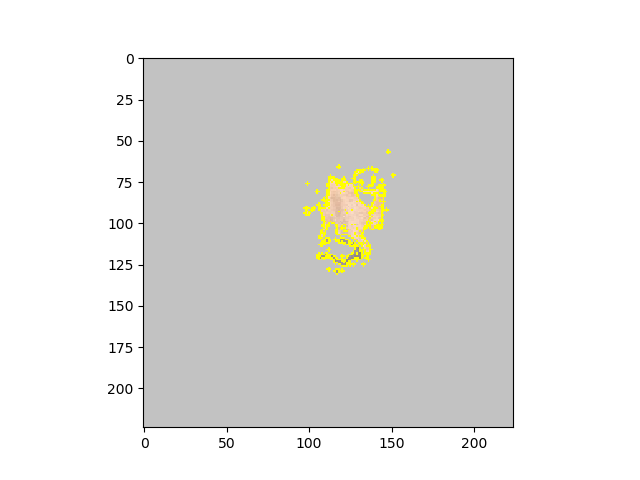

In [23]:
%matplotlib notebook

temp = (temp - np.min(temp))
temp = temp/np.max(temp)

plt.imshow(mark_boundaries(temp / 2 + 0.5, mask), cmap='plasma')
plt.show()

### Gradient-based Models: magnitude of gradient reflects importance (attribution) of input to output scores

#### - iNNvestigate toolbox (https://github.com/albermax/innvestigate)
- **Gradients** 
- **Guided-backprop** (https://arxiv.org/abs/1412.6806)

Import functions from iNNvestigate:

In [24]:
from innvestigate.utils import model_wo_softmax
from innvestigate import create_analyzer

In [25]:
model_without_softmax = model_wo_softmax(model)

In [26]:
x = X_train[0]
x = np.reshape(x, (1, 224, 224, 3))

In [27]:
def innvestigate_analyzer(str, model, img): 
    analyzer = create_analyzer(str, model)
    res = analyzer.analyze(img)
    
    return res

In [28]:
img_analyzed = innvestigate_analyzer("gradient", model_without_softmax, x)

In [29]:
def plot_interpretation(img): 
    img = img.sum(axis=np.argmax(np.asarray(img.shape) == 3))
    img /= np.max(np.abs(img))
    img = np.reshape(img, (224, 224))

    plt.imshow(img, cmap='plasma')
    plt.show()    

<IPython.core.display.Javascript object>


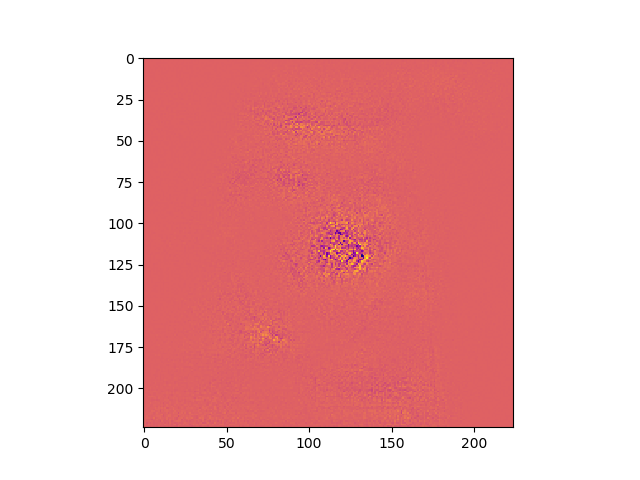

In [30]:
%matplotlib notebook

plot_interpretation(img_analyzed)

It is quite difficult to interpret image based on pure gradients... 

In [31]:
img_analyzed = innvestigate_analyzer("guided_backprop", model_without_softmax, x)

<IPython.core.display.Javascript object>


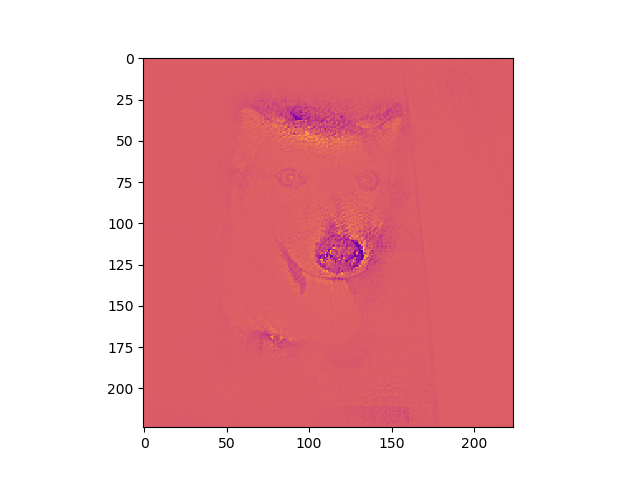

In [32]:
%matplotlib notebook

plot_interpretation(img_analyzed)

#### - Keras Visualization Toolkit (https://raghakot.github.io/keras-vis/)

- **Grad-CAM**: Good visualization is class-specific.

- **Guided-Grad-CAM**: uses Grad-CAM as mask for Guided Backpropagation

![alt text](aux_imgs/guided_grad_cam_image.png "Title")

In [33]:
from vis.visualization import visualize_cam
from vis.utils.utils import apply_modifications

In [39]:
image = cv2.imread("cat_and_dog.png")
image_resized = cv2.resize(image, (224, 224))
image_processed = preprocess_input(image_resized)
input_img = np.reshape(image_processed, (1,224,224,3))

In [40]:
pred = model.predict(input_img)
print(np.argmax(pred, axis=1))

[0]


<IPython.core.display.Javascript object>


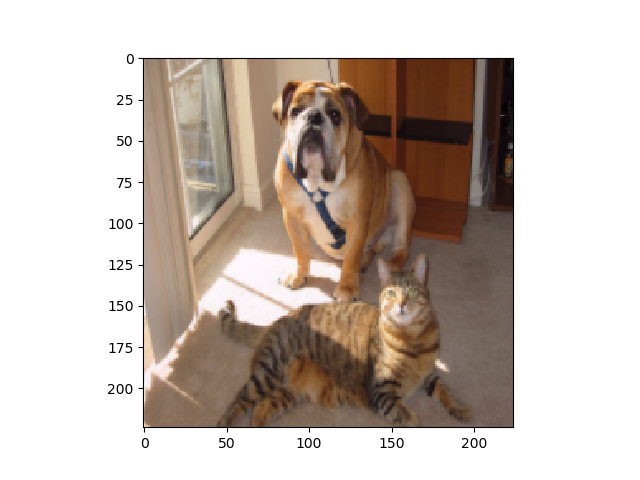

In [41]:
%matplotlib notebook 
img_to_show = np.array(image_processed, dtype='int')
img_to_show = processed_to_original(img_to_show)

plt.imshow(img_to_show, cmap='plasma')
plt.show()

In [42]:
img = innvestigate_analyzer("guided_backprop", model_without_softmax, input_img)

<IPython.core.display.Javascript object>


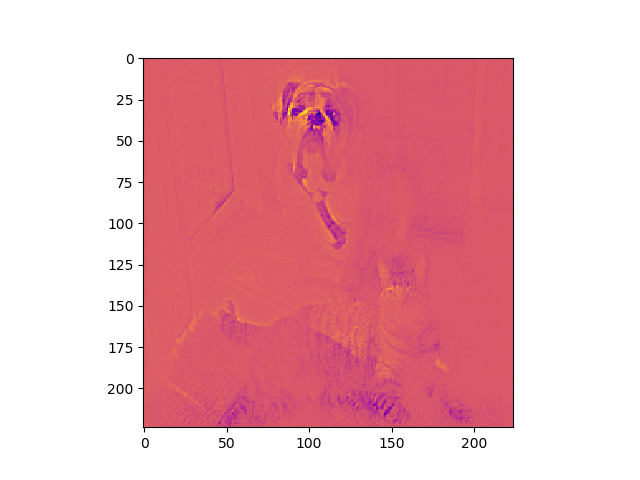

In [43]:
%matplotlib notebook

plot_interpretation(img)

- **Grad-CAM "dog"**

<IPython.core.display.Javascript object>


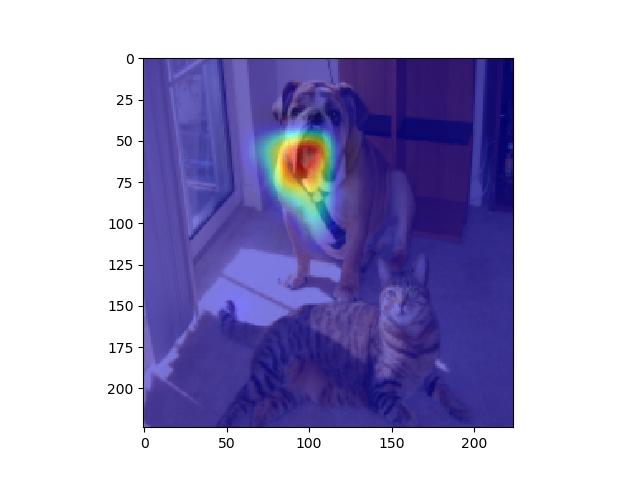

In [44]:
%matplotlib notebook

model.layers[-1].activation='linear'

heatmaps = visualize_cam(model=model, layer_idx=24, filter_indices=1, seed_input=input_img, penultimate_layer_idx=17)

%matplotlib notebook
plt.imshow(heatmaps, cmap='plasma')
plt.imshow(img_to_show, interpolation='nearest', alpha=0.5, cmap='plasma')
plt.show()

In [45]:
analyzer = create_analyzer("guided_backprop", model) # here we are using gradient method, but you can use of any other 
img = analyzer.analyze(input_img)

guided_grad_cam = img * heatmaps 

<IPython.core.display.Javascript object>


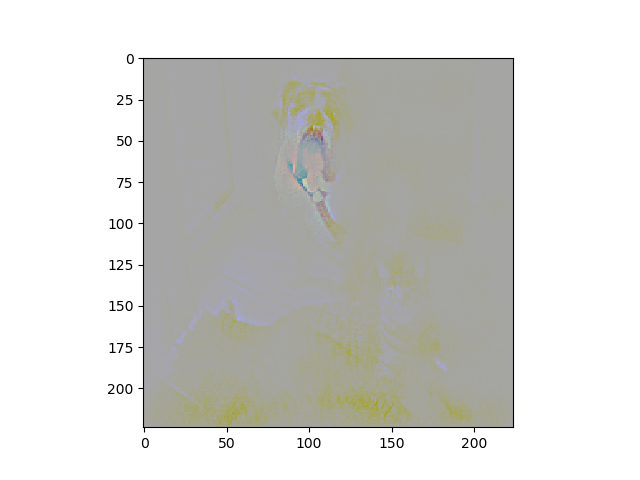

In [46]:
%matplotlib notebook 

guided_grad_cam = np.reshape(guided_grad_cam, (224,224,3))
guided_grad_cam = processed_to_original(guided_grad_cam)

plt.imshow(guided_grad_cam, cmap='plasma')
plt.show()

### Study the impact of model parameters in the quality of the explanations

In [47]:
checkpoint = ModelCheckpoint('Models/cats_vs_dogs_overfit.hdf5', monitor='loss', save_best_only=True, verbose=True)

In [111]:
def clf_from_fts_over(inputs): 
    flat = Flatten()(inputs)
    dense1 = Dense(1000, activation='relu', name='first_dense')(flat)
    dense1 = Dense(500, activation='relu', name='second_dense')(dense1)
    dense1 = Dense(250, activation='relu', name='third_dense')(dense1)
    dense1 = Dense(125, activation='relu', name='forth_dense')(dense1)
    dense1 = Dense(75, activation='relu', name='fifth_dense')(dense1)
    dense1 = Dense(25, activation='relu', name='sixth_dense')(dense1)
    dense1 = Dense(2, activation='softmax', name='clf')(dense1)
    
    return dense1

In [49]:
vgg_fts = vgg16(inputs) 
clf = clf_from_fts_over(vgg_fts) 

model = Model(inputs=inputs, outputs=clf)
model.summary()

model.load_weights('Models/vgg_imagenet.hdf5', by_name=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_for_cats_vs_dogs (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [50]:
model.compile(optimizer=adam(lr=0.00001), loss=categorical_crossentropy, metrics=['acc'])

In [51]:
def my_generator_o(X, y, minibatch_size):
    keras_datagen = ImageDataGenerator(rotation_range=0,
                                       zoom_range=0,
                                       width_shift_range=0,
                                       height_shift_range=0,
                                       horizontal_flip=False,
                                       )
    X = np.array(X)
    
    N = len(X)
    while True:
        indices = np.random.choice(N, N, False)
        
        for i in range(N // minibatch_size):
            batch_indices = indices[i*minibatch_size:(i+1)*minibatch_size]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]
            

            batch_X, batch_y = next(keras_datagen.flow(batch_X, \
                                              batch_y, \
                                              batch_size=minibatch_size, \
                                              shuffle=False))
            
            yield (batch_X, batch_y)

In [ ]:
model.fit_generator(my_generator_o(X_train, y_train, 2), steps_per_epoch = X_train.shape[0]/2, epochs=50,\
                verbose=2, callbacks=[checkpoint], validation_data=(X_validation, y_validation))

In [87]:
from keras.models import load_model 

model_overfit = load_model('Models/cats_vs_dogs_overfit.hdf5')

In [88]:
preds = model_overfit.predict(X_train, batch_size=1)
preds = np.argmax(preds, axis=1)
print(preds)

l = np.argmax(y_train, axis=1)
print(l)

[1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 0 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0
 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1
 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 1 0
 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0
 0 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0
 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0
 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0
 0 0 0 1 1 1]
[1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 1 0 0 

In [89]:
model_overfit = model_wo_softmax(model_overfit)

In [90]:
x = X_train[0]
x = np.reshape(x, (1, 224, 224, 3))

In [97]:
img_overfit = innvestigate_analyzer("gradient", model_overfit, x)

<IPython.core.display.Javascript object>


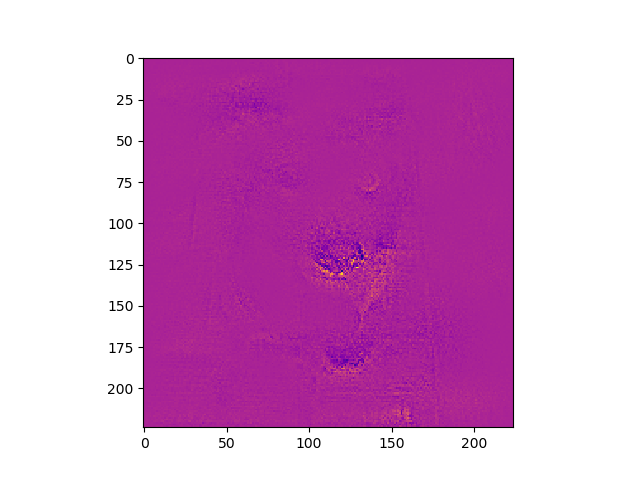

In [98]:
%matplotlib notebook

plot_interpretation(img_overfit)

In [99]:
img_overfit = innvestigate_analyzer("guided_backprop", model_overfit, x)

<IPython.core.display.Javascript object>


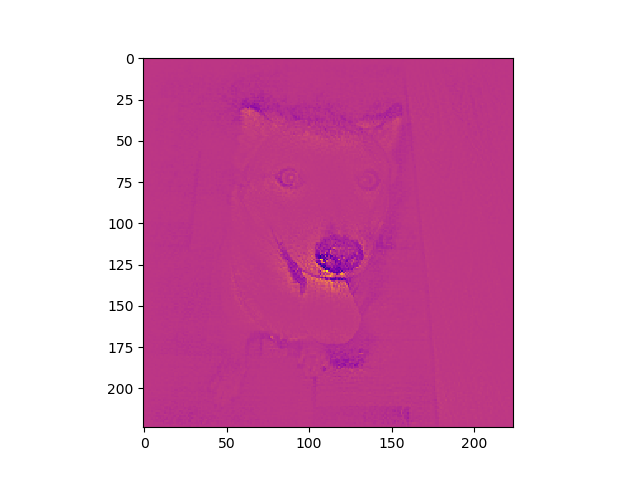

In [100]:
%matplotlib notebook

plot_interpretation(img_overfit)

In [112]:
vgg_fts = vgg16(inputs) 
clf = clf_from_fts_over(vgg_fts) 

model = Model(inputs=inputs, outputs=clf)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_for_cats_vs_dogs (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [113]:
model.compile(optimizer=adam(lr=0.00001), loss=categorical_crossentropy, metrics=['acc'])

In [115]:
checkpoint = ModelCheckpoint('Models/cats_vs_dogs_underfit.hdf5', monitor='loss', save_best_only=True, verbose=True)

In [116]:
model.fit_generator(my_generator_o(X_train, y_train, 2), steps_per_epoch = X_train.shape[0]/2, epochs=1,\
                verbose=2, callbacks=[checkpoint], validation_data=(X_validation, y_validation))

Epoch 1/1
 - 26s - loss: 0.6946 - acc: 0.5022 - val_loss: 0.6915 - val_acc: 0.5200

Epoch 00001: loss improved from inf to 0.69462, saving model to Models/cats_vs_dogs_underfit.hdf5


In [118]:
model_underfit = model_wo_softmax(model)

In [119]:
img_underfit = innvestigate_analyzer("gradient", model_underfit, x)

<IPython.core.display.Javascript object>


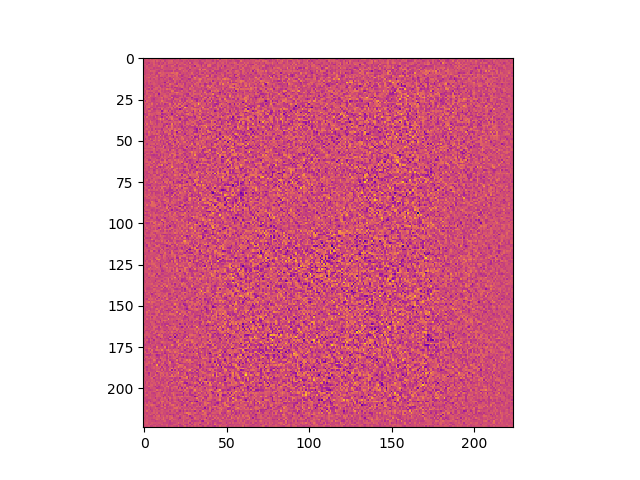

In [120]:
%matplotlib notebook

plot_interpretation(img_underfit)

In [121]:
img_underfit = innvestigate_analyzer("guided_backprop", model_underfit, x)

<IPython.core.display.Javascript object>


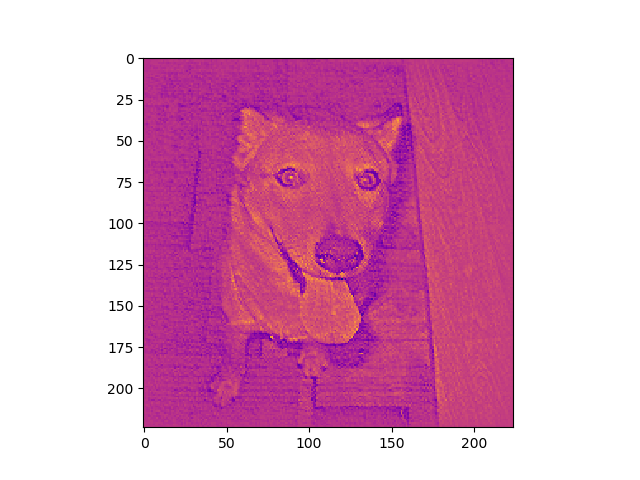

In [122]:
%matplotlib notebook

plot_interpretation(img_underfit)